In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# import custom functions
import sys
sys.path.append("../../../../")
import utils
from tqdm import tqdm
import torch


from skimage.io import imread
from scipy.io import loadmat
from skimage.transform import resize
from skimage.measure import regionprops

import scipy
import skimage
# import custom functions
import os
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import graph

##
import harmonypy as hm
import anndata as ad
import scanpy as sc
import scanpy.external as sce

In [2]:
cnngnn_embed = np.load('../data/Xton_double_snap_combo_stable.npy')
cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))
snap = pd.DataFrame(cnngnn_embed)
snap.to_csv('../data/Xton_double_snap_combo_stable.csv')

sc.pp.scale(cnngnn_adata)
sc.pp.neighbors(cnngnn_adata, n_neighbors=10, use_rep='X') # this dataset need more local nn
sc.tl.umap(cnngnn_adata)
sc.tl.leiden(cnngnn_adata, resolution=1)

/tmp/ipykernel_678276/2464755283.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from scipy.stats import entropy

def cluster_refine(label, label_ref, entropy_threshold = 0.75, concen_threshold = 1, max_breaks = 3, size_lim = 50):
    label_out = label.copy()
    label_out.name = label_out.name + '-refined'
    label_out = label_out.astype(str)
    ll = np.unique(label)
    for l in ll: # each cluster
        ref_l = label_ref[label == l] # get input cluster
        ref_l_freq = ref_l.value_counts() # table
        if entropy(ref_l_freq) > entropy_threshold: # if high entro
            for i in np.arange(max_breaks-1):
                bb = label[label_ref == ref_l_freq.index[i]] # get most abun input cluster
                #print(bb)
                if entropy(bb.value_counts()) < concen_threshold and ref_l_freq.iloc[i] >= size_lim:
                    label_out[(label == l) & (label_ref == ref_l_freq.index[i])] = l + '-' + str(i)
    
    return label_out.astype('category')

### another help to clean results
def clean_cluster(label):
    ll = label.value_counts().index.to_list()
    i = 0
    dd = {}
    for l in ll:
        dd[l] = str(i)
        i = i+1
    res = []
    for item in label:
        t = dd[item]
        res.append(t)
    return res

In [4]:
res05_input = np.load('../data/Xton_feature_labels_res0.5.npy')
cnngnn_adata.obs['input'] = res05_input
# cellsnap cluster guarding
snapres1 = cluster_refine(label = cnngnn_adata.obs['leiden'], label_ref=cnngnn_adata.obs['input']) # since larger dataset
snapres1f = clean_cluster(snapres1)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'snapres1'}, xlabel='UMAP1', ylabel='UMAP2'>

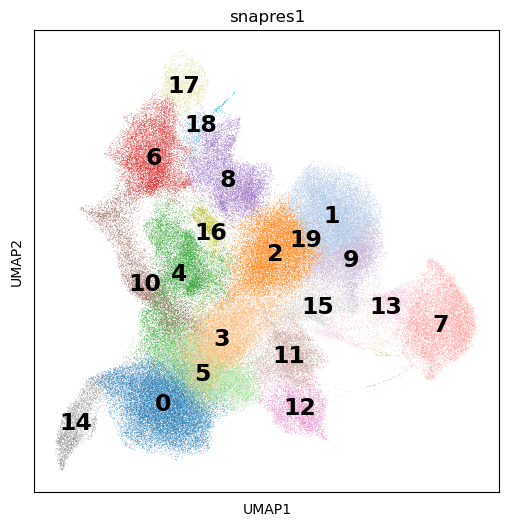

In [5]:
#snapres1.value_counts()
plt.rcParams["figure.figsize"] = (6, 6)
cnngnn_adata.obs['snapres1'] = snapres1f
sc.pl.umap(cnngnn_adata, color='snapres1', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

In [6]:
feat_embed = pd.read_csv('../data/Xton_sub_pc.csv').iloc[:,:30].to_numpy()
counts_adata = ad.AnnData((feat_embed))

/tmp/ipykernel_678276/2745877034.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  counts_adata = ad.AnnData((feat_embed))


In [7]:
sc.pp.neighbors(counts_adata, n_neighbors=10, use_rep = 'X') # this dataset need more local nn
sc.tl.umap(counts_adata)
sc.tl.leiden(counts_adata, resolution=1)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

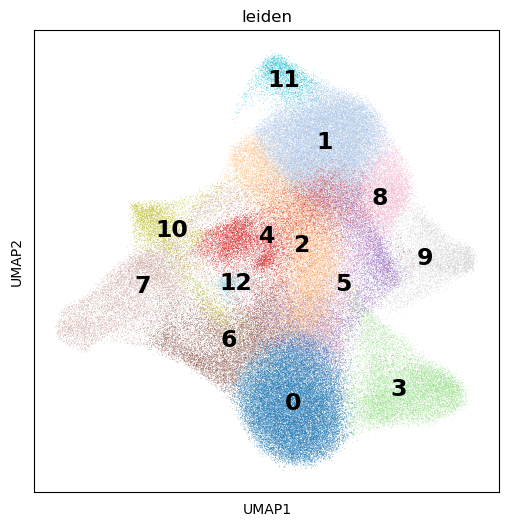

In [8]:
#snapres1.value_counts()
cnngnn_adata.obs['input'] = res05_input
plt.rcParams["figure.figsize"] = (6, 6)
sc.pl.umap(counts_adata, color='leiden', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

In [9]:
meta = pd.read_csv('../data/Xton_sub_meta.csv')
meta['snapres1'] = snapres1f
meta['featres1'] = counts_adata.obs['leiden'].values
meta.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,barcode,y_centroid2,n_counts,leiden,snapres1,featres1
0,adkkpojc-1,9079.155273,852.034607,210,0,0,0,0,210,388.343764,18.197969,21061,-852.034607,210.0,9,18,7
1,adklbgog-1,9053.489258,836.870728,84,0,0,0,0,84,651.920805,37.840939,21062,-836.870728,84.0,9,17,7
2,adklbigp-1,9055.033203,858.775208,70,0,0,0,0,70,85.209847,38.924689,21063,-858.775208,70.0,9,17,7
3,adklblhc-1,9071.123047,864.167419,187,0,0,0,0,187,67.418284,29.261251,21064,-864.167419,187.0,9,17,7
4,adklcljc-1,9058.196289,865.665100,83,0,0,0,0,83,61.909221,34.092970,21065,-865.665100,83.0,9,17,7


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


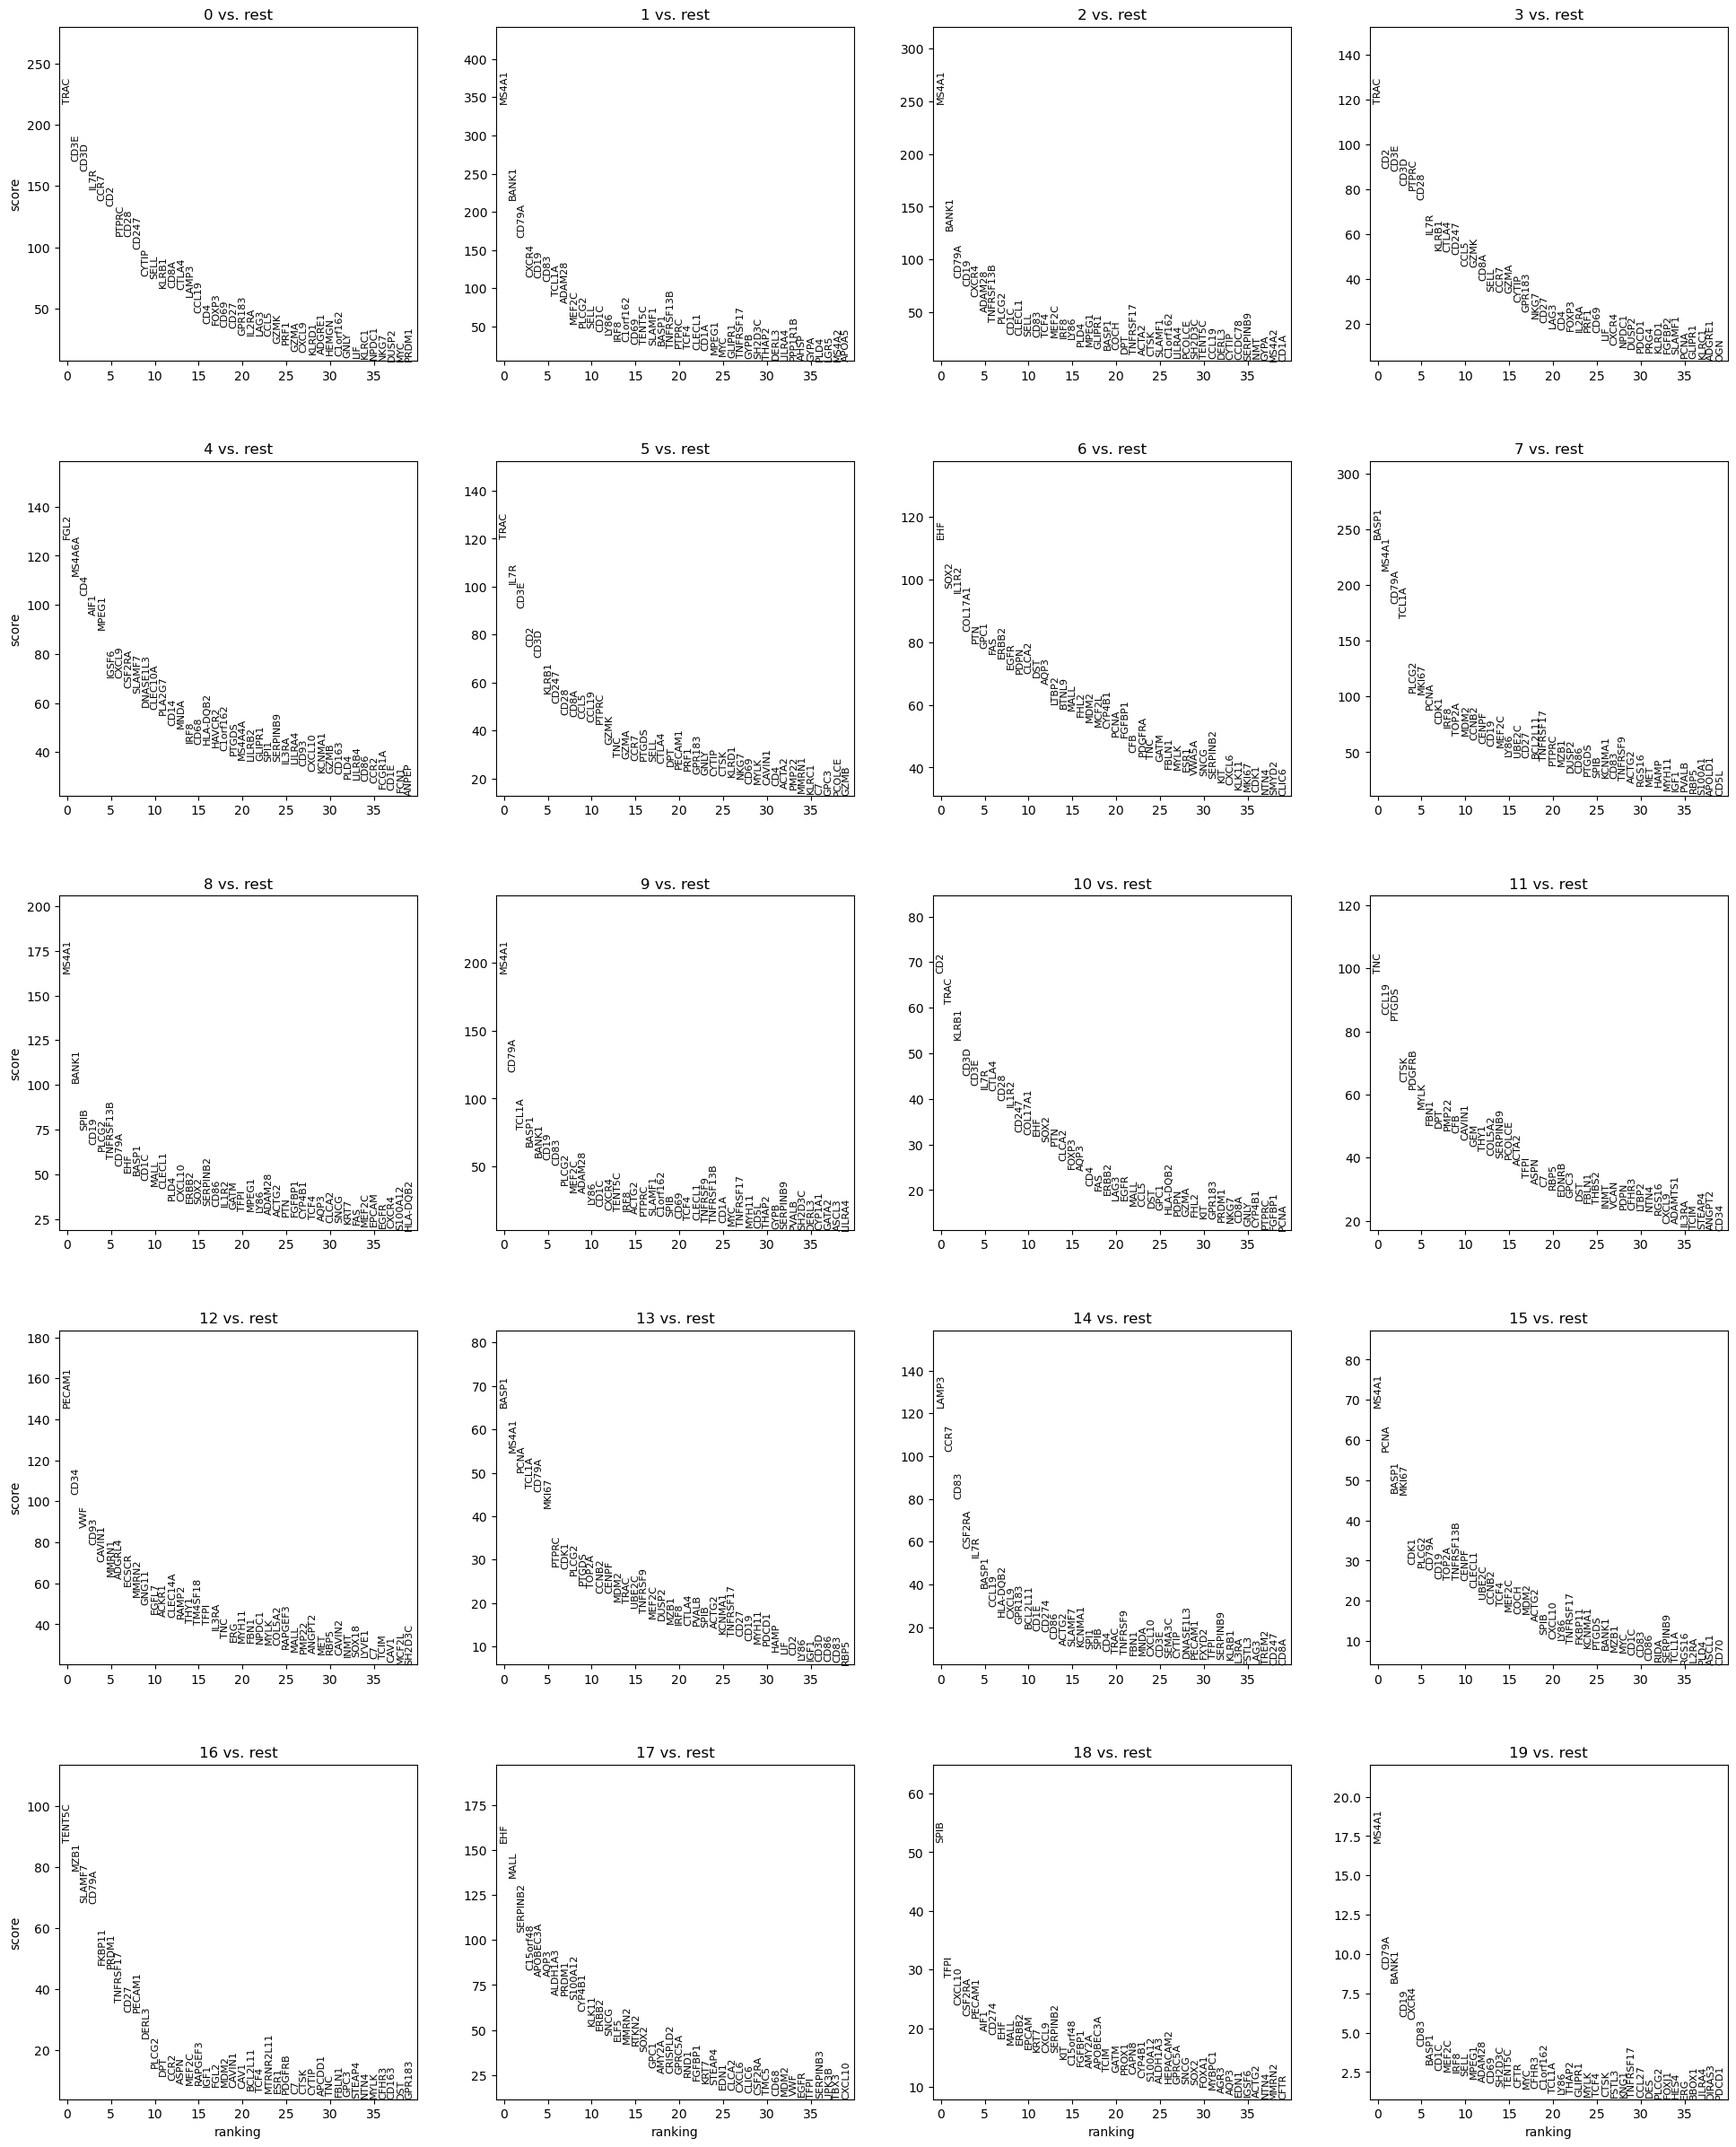

In [10]:
df_count = pd.read_csv('../data/Xton_sub_norm.csv')
gene_names = pd.read_csv('../data/gene_names.csv')
df_count.head()
adata = ad.AnnData(
    df_count, dtype=np.float32
)
sc.pp.scale(adata, max_value=10)
adata.obsm['X_umap'] = cnngnn_adata.obsm['X_umap']
adata.obs['leiden'] = cnngnn_adata.obs['snapres1'].values
adata.var_names = gene_names.iloc[:,0].to_list()

import warnings
warnings.filterwarnings('ignore')

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=40, sharey=False)

In [11]:
plt.rcParams["figure.figsize"] = (10, 10)

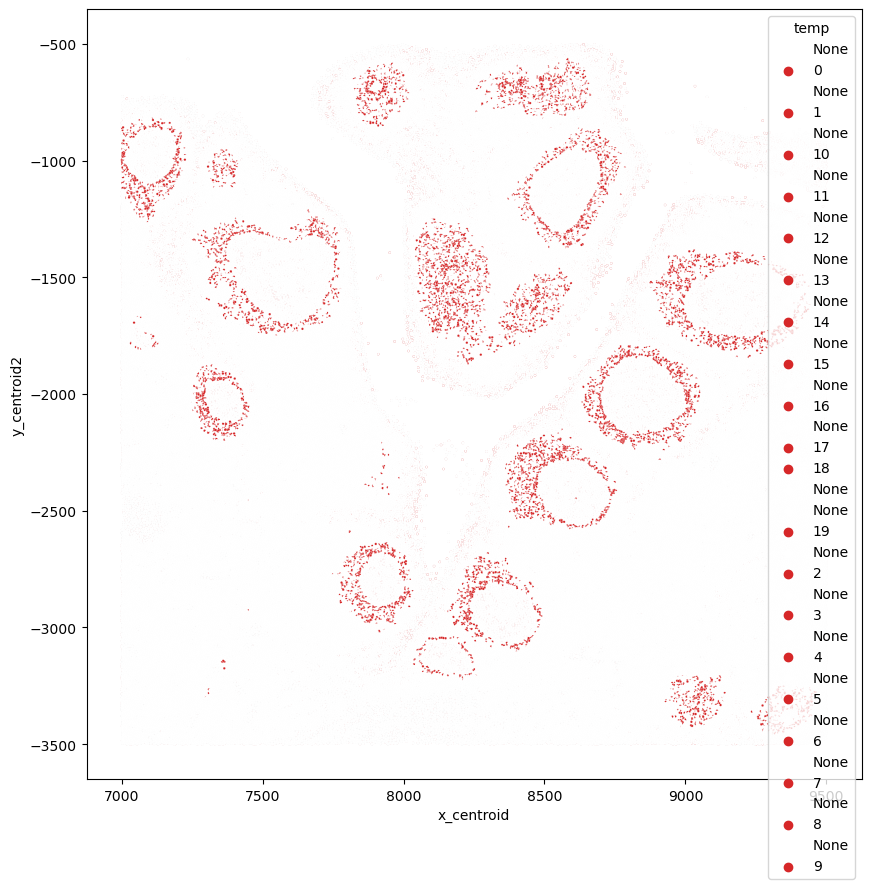

In [13]:
import seaborn as sns  ## takes

celltypes = np.unique(meta['snapres1'])

for item in celltypes:
    target = item
    tp = meta.copy()
    tp['temp'] = 'None'
    tp.loc[(tp['snapres1'] == target),'temp'] = target

    palette = {"None":"w",
           target:"tab:red", }

    plot1 = sns.scatterplot(data=tp, x="x_centroid", y="y_centroid2", hue="temp", s = 3, palette=palette)
    fig = plot1.get_figure()
    savedir = '../plots/xton_snapres1_' + item + '.png'
    fig.savefig(savedir, dpi = 300)
    #plt.close
    

In [16]:
## put in cellsnap clustering human broad annotations:

meta['snapres1_ann'] = meta['snapres1']

new_cluster_names = {
    '0':'T', '1':'B', '2':'B', '3':'T', '4':'Macrophage', '5':'T',
    '6':'Stromal/Fibro', '7':'B', '8':'B', '9':'B', '10':'T', '11':'Stromal/Fibro',
    '12':'Vessel', '13':'B', '14':'DC', '15':'B', '16':'B', '17':'Stromal/Fibro',
    '18':'Stromal/Fibro', '19':'B'
}

meta=meta.replace({"snapres1_ann": new_cluster_names})
meta.snapres1_ann.value_counts()

snapres1_ann
B                66536
T                52952
Stromal/Fibro    18942
Macrophage       12964
Vessel            3927
DC                2938
Name: count, dtype: int64

In [17]:
comp = meta.groupby(['featres1','snapres1_ann']).size()
pd.set_option('display.max_rows', 10000)
print(comp)

featres1  snapres1_ann 
0         B                30984
          DC                   8
          Macrophage          13
          Stromal/Fibro       20
          T                   47
          Vessel               2
1         B                  105
          DC                 187
          Macrophage         259
          Stromal/Fibro       33
          T                26721
          Vessel               4
2         B                 5453
          DC                  68
          Macrophage         191
          Stromal/Fibro       62
          T                12580
          Vessel               2
3         B                13160
          DC                   0
          Macrophage           8
          Stromal/Fibro        1
          T                   25
          Vessel               0
4         B                  331
          DC                  55
          Macrophage       10566
          Stromal/Fibro      206
          T                 1596
          Vessel   

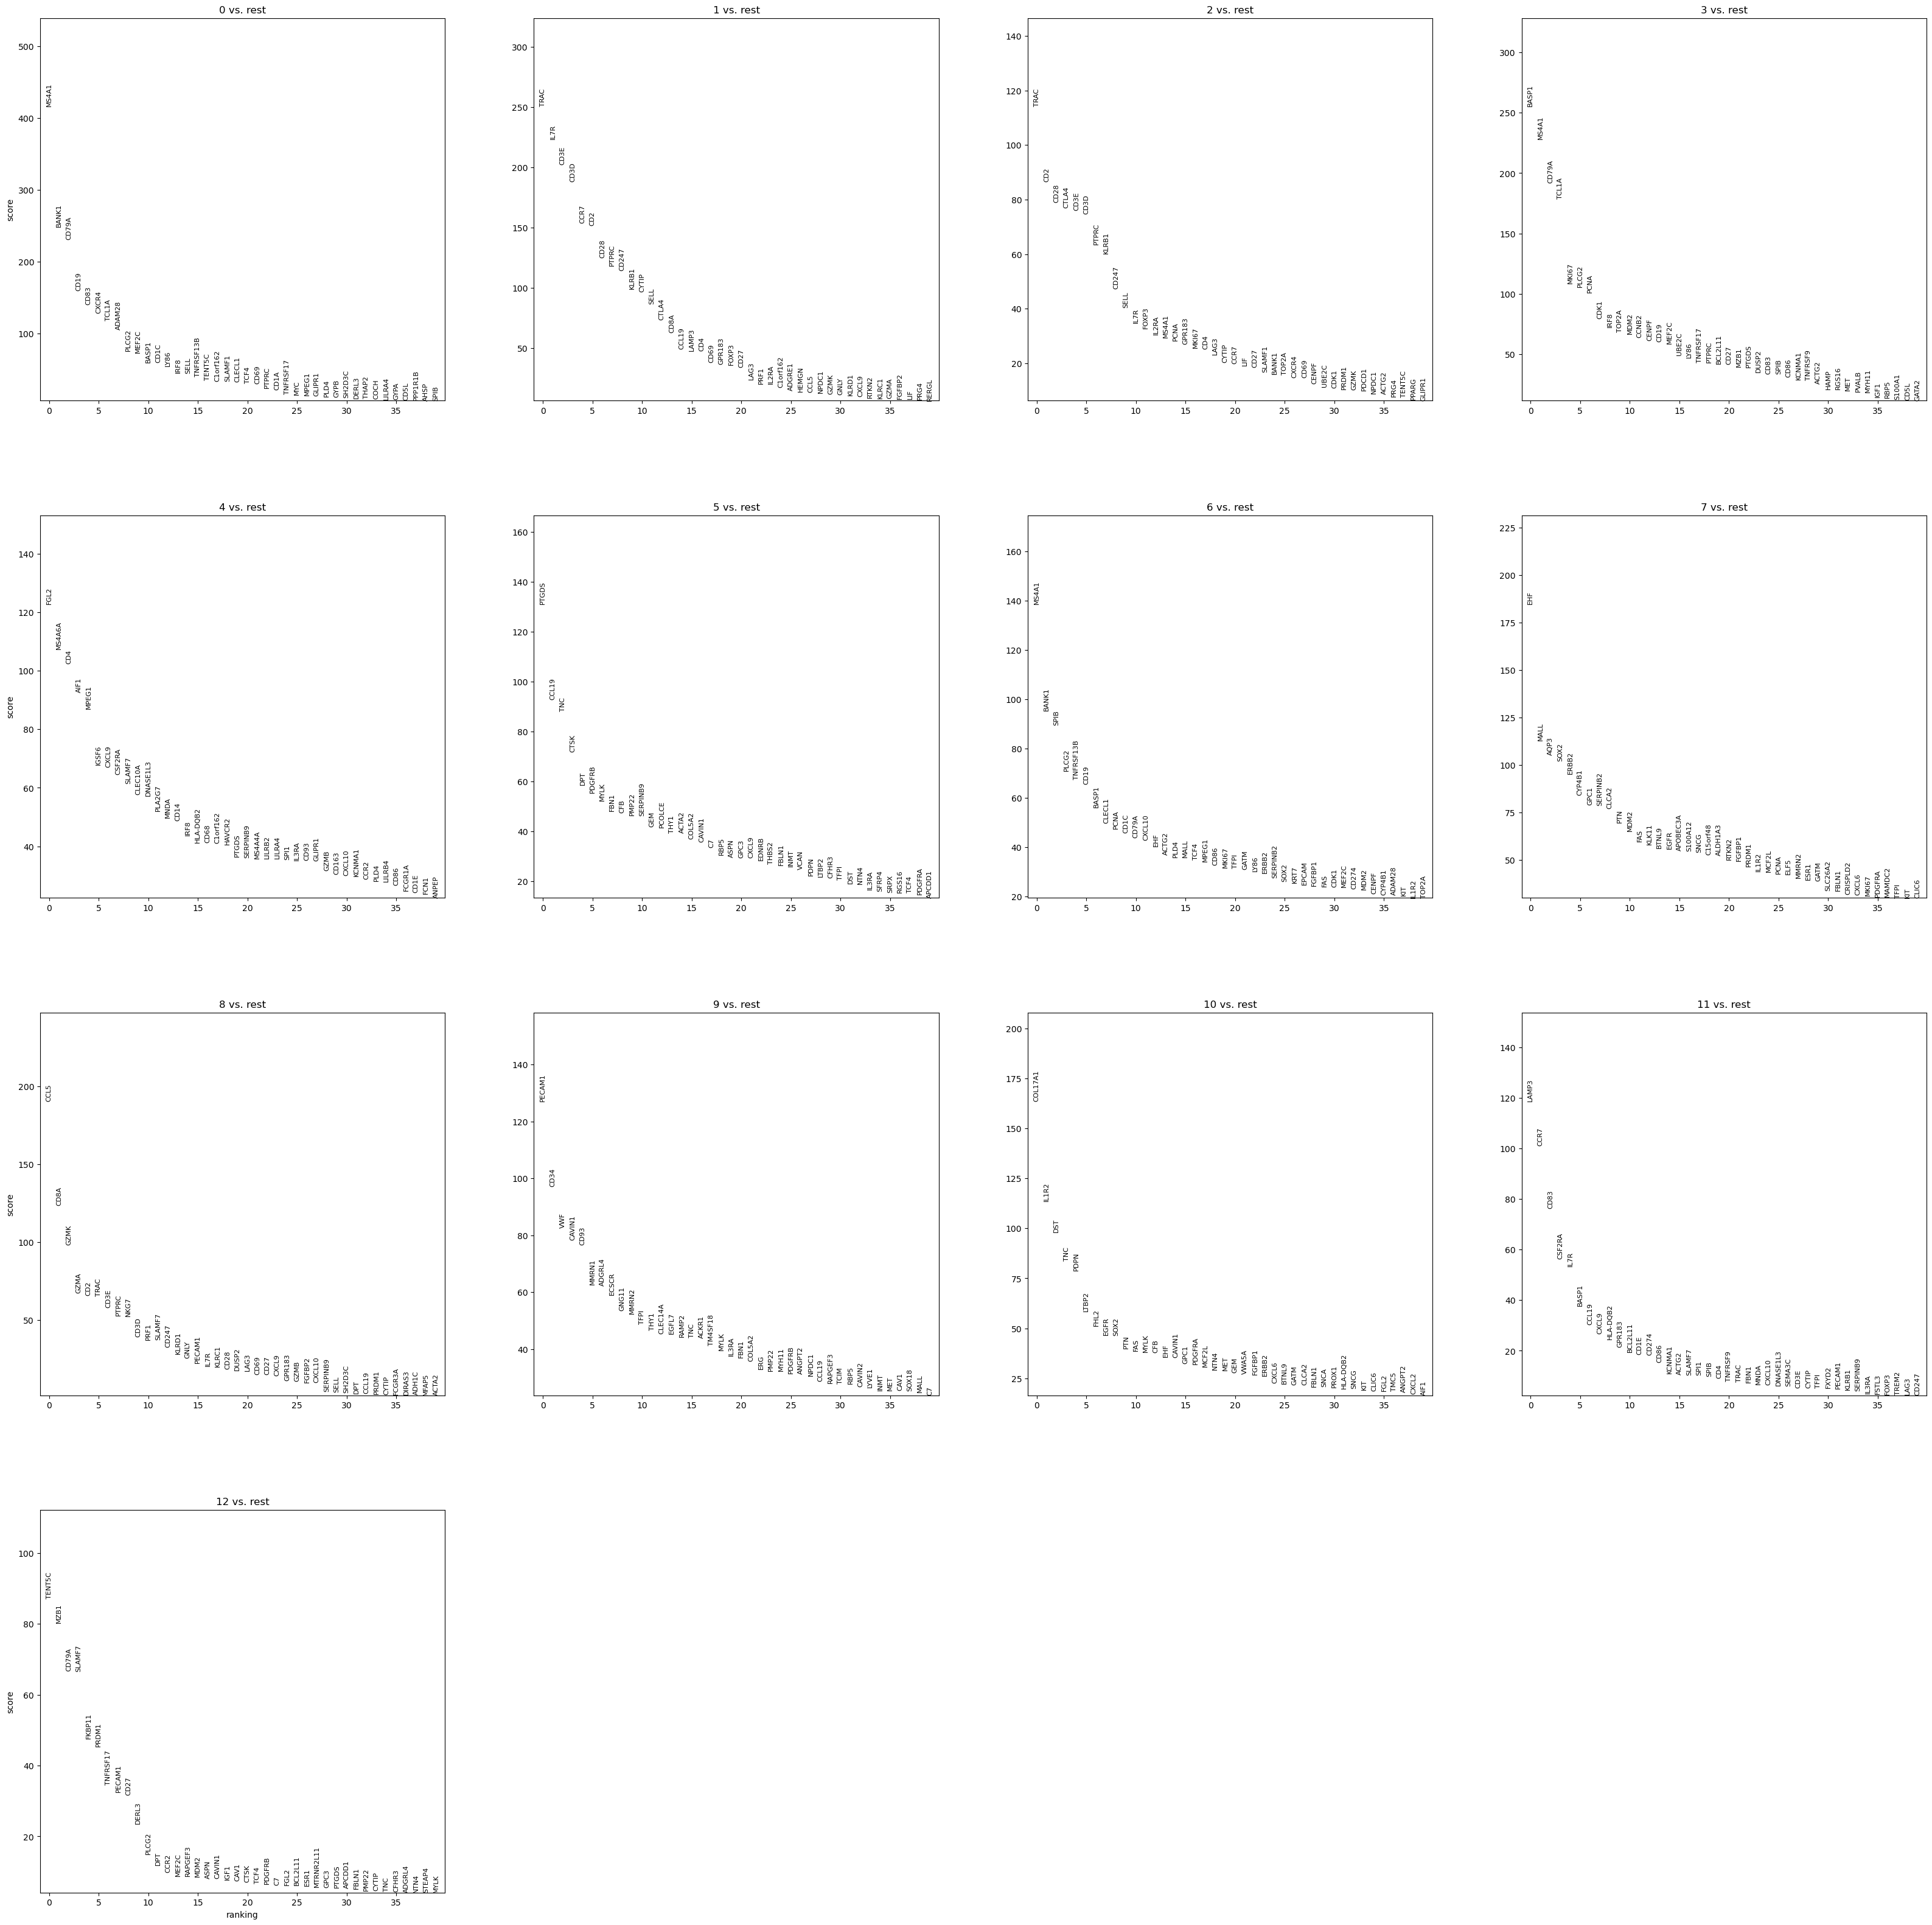

In [14]:
adata.obs['leiden'] = counts_adata.obs['leiden'].values
adata.var_names = gene_names.iloc[:,0].to_list()

import warnings
warnings.filterwarnings('ignore')

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=40, sharey=False)

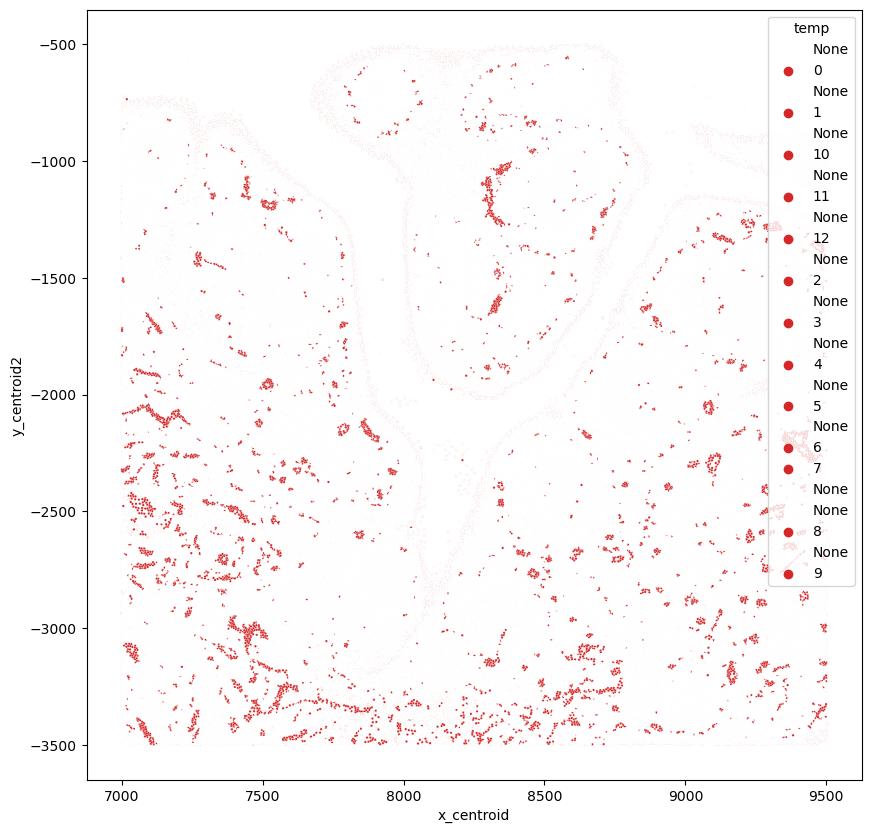

In [15]:
import seaborn as sns  ## takes
plt.rcParams["figure.figsize"] = (10, 10)
celltypes = np.unique(meta['featres1'])

for item in celltypes:
    target = item
    tp = meta.copy()
    tp['temp'] = 'None'
    tp.loc[(tp['featres1'] == target),'temp'] = target

    palette = {"None":"w",
           target:"tab:red", }

    plot1 = sns.scatterplot(data=tp, x="x_centroid", y="y_centroid2", hue="temp", s = 3, palette=palette)
    fig = plot1.get_figure()
    savedir = '../plots/xton_featres1_' + item + '.png'
    fig.savefig(savedir, dpi = 300)
    #plt.close
    

In [18]:
## put in cellsnap clustering human broad annotations:

meta['featres1_ann'] = meta['featres1']

new_cluster_names = {
    '0':'B', '1':'T', '2':'T', '3':'B', '4':'Macrophage', '5':'Stromal/Fibro',
    '6':'B', '7':'Stromal/Fibro', '8':'T', '9':'Vessel', '10':'Stromal/Fibro', '11':'DC',
    '12':'B'
}

meta=meta.replace({"featres1_ann": new_cluster_names})
meta.featres1_ann.value_counts()

featres1_ann
B                56905
T                53221
Stromal/Fibro    27022
Macrophage       12801
Vessel            5432
DC                2878
Name: count, dtype: int64

In [18]:
meta.to_csv('../data/Xton_sub_meta_snap_feat_clusters.csv')